# Prospecção de Dados (Data Mining) DI/FCUL - HA3

## Third Home Assignement (MC/DI/FCUL - 2024)

### Fill in the section below

### GROUP: `13`

* Miguel Landum, 35019 - Hours worked on the project
* Niklas Schmitz, 62689 - Hours worked on the project
* Pol Parra, 62692 - Hours worked on the project
* Til Dietrich, 62928 - Hours worked on the project




The purpose of this Home Assignment is
* Find similar items with Local Sensitivity Hashing
* Do Dimensionality Reduction

**NOTE 1: Students are not allowed to add more cells to the notebook**

**NOTE 2: The notebook must be submited fully executed**

**NOTE 3: Name of notebook should be: HA3_GROUP-XX.ipynb (where XX is the group number)**


**NOTE to run code locally:** add data (data_d3.pickle, data_d4.pickle) to **assignment-3/data/** folder

## 1. Read the Dataset

The dataset correspond to about 99% of the Human Proteome (set of known Human Proteins - about 19,500), coded with specific structural elements. They are presented in a dictionary where the key is the [UniprotID](https://www.uniprot.org/) of the protein and the value is a set of indices of a specific structural characteristic

Students can use one of two datasets, that are **not** subsets of each other: 
* `data_d3.pickle` - smaller set of structural features (2048)
* `data_d4.pickle` - much larger set of structural features (20736) **Note:** This dataset has been Zipped to fit into moodle. Students should unzip it before usage 

Select **one** of the datasets and perform all analyses with it. 

It may be adviseable the usage of sparse matrices, especially for the `d4` dataset



In [83]:
# !pip install datasketch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 2.3 MB/s eta 0:00:00a 0:00:01


In [1]:
### Your code Here
import pickle
from itertools import islice

data_d3=pickle.load(open("data/data_d3.pickle", "rb"))
data_d4=pickle.load(open("data/data_d4.pickle", "rb"))

first_elements = list(islice(data_d3, 5))
print(first_elements[0])
print(data_d3[first_elements[0]])
print(len(data_d3[first_elements[0]]))
print(len(data_d3[first_elements[1]])) # => elements in dict have different amount of elements in them

A0A024R1R8
{1, 771, 775, 263, 137, 11, 531, 1176, 922, 30, 927, 1185, 673, 675, 423, 296, 1704, 2043, 813, 304, 48, 52, 693, 1080, 1083, 1211, 1085, 1469, 69, 454, 1865, 458, 842, 1609, 1618, 467, 1109, 214, 1237, 473, 90, 603, 1379, 229, 1768, 1513, 1260, 109, 1645, 1007, 112, 1521, 242, 2035, 1652, 1525, 1270, 119, 1017, 123, 508, 1149}
62
178


## 2. Perform Local Sensitivity Hashing (LSH)

* examine the selected dataset in terms of similarities and select a set of LSH parameters able to capture the most similar proteins
* Comment your results

**BONUS POINTS:** It might be interesting to identify **some** of the candidate pairs in Uniprot, to check if they share some of the same properties (e.g. for [protein P28223](https://www.uniprot.org/uniprotkb/P28223/entry))


In [31]:
# Niklas Code

### Add supporting functions here
import numpy as np
import time
from scipy.sparse import csr_matrix
from datasketch import MinHash, MinHashLSH
import matplotlib.pyplot as plt
import pandas as pd

def JaccardSim(d1, d2):
    a =np.inner(d1,d2)
    bc=np.sum(d1+d2)-a
    return a/bc

def convert_to_binary_matrix(data):
    # Extract all unique values to create the universe of elements
    all_values = set()
    for values in data.values():
        all_values.update(values)

    # Create a mapping from values to index
    value_to_index = {value: idx for idx, value in enumerate(all_values)}

    # Number of unique elements
    num_elements = len(all_values)

    # Prepare data for csr_matrix
    rows = []
    cols = []
    data_values = []

    for key, values in data.items():
        for value in values:
            rows.append(key)
            cols.append(value_to_index[value])
            data_values.append(1)  # Presence of the element

    # Convert document IDs to numerical indices
    keys_to_index = {}
    indices_to_key = {}
    for idx, doc in enumerate(data.keys()):
        keys_to_index[doc] = idx
        indices_to_key[idx] = doc
    row_indices = [keys_to_index[doc] for doc in rows]

    # Create and return CSR matrix
    return csr_matrix((data_values, (row_indices, cols)), shape=(len(data), num_elements)), keys_to_index, indices_to_key

def MakeBucketsT(TDocs, perms, N, B, R, NB):
    Buckets={}
    all_docs=set(range(N))
    for b in range(B):
        SIGS=np.zeros((N, R), dtype="int32")           # initializes line sig
        for r in range(R):
            perm=perms[b*R+r]
            L=all_docs.copy()                         # gets all docs as a set
            i=0 
            while len(L)>0:
                elem=perm[i]                          # get new element  from permutation
                docs_found=TDocs[elem] & L            # get all the docs with a set bit on that elem that are still on the list
                if len(docs_found)>0:                 # if anything was found
                    SIGS[list(docs_found), r]=i       #   set the line sig to the current position from the perm
                    L=L-docs_found                    #   update the current list removing the found docs
                i+=1                                  # update the current position
                if i == len(perm):
                    SIGS[list(L), r] = i
                    L = set()                               
                                                      # now make the hashes for each document
        for d in range(N):
            bucket = hash(tuple(SIGS[d])) % NB
            Buckets.setdefault((b, bucket),set()).add(d)
    return Buckets

def LSHT(Data, B, R, NB=28934501):
    N, M = Data.shape
    # Convert to Sparse Row matrix format if it's not already
    if not isinstance(Data, csr_matrix):
        Data = csr_matrix(Data)
    # Transpose the data set
    DataT = Data.transpose() # use method transpose() of scipy.csr_matrix
    DataT = [set(DataT.indices[DataT.indptr[i]:DataT.indptr[i + 1]]) for i in range(M)]
    P = B * R # number of permutations
    # Generating permutations
    perms = [np.random.permutation(M) for i in range(P)]
    buckets = MakeBucketsT(DataT, perms, N, B, R, NB)
    return buckets

# Function to time LSHT for given B and R
def time_LSHT(data, bands, rows):
    start_time = time.time()
    buckets = LSHT(data, bands, rows)
    end_time = time.time()
    return buckets, end_time - start_time

def print_similar_protein_pairs(buckets):
    for b, buck in buckets:
        if len(buckets[(b,buck)])>1:
            print("Band", b, "suggests these similar docs:", buckets[(b,buck)])

def DrawSimPlot(B, R):
    S=np.arange(0,1.0,.01)
    v=(1/B)**(1/R)
    P=1-(1-S**R)**B
    plt.figure(figsize=(7,5))
    plt.plot(S,P)
    plt.axvline(x = v, linestyle ="--", color ='r')
    plt.title("Candidate pairs probability for B=%d and R=%d" % (B,R))
    plt.xlabel("Document Similarity")
    plt.ylabel("Probability of being a candidate pair")

    plt.grid()
    plt.show()
    
def plot_timing_results(B_values, R_values, timing_results):
    # Plotting
    fig, ax = plt.subplots()
    if len(R_values) == 1:
        for R_val in R_values:
            timing_for_R = [timing_results[(B_val, R_val)] for B_val in B_values]
            ax.plot(B_values, timing_for_R, label=f"R={R_val}")
            ax.set_xlabel("Number of Bands per row (B)")
    else:
        for B_val in B_values:
            timing_for_B = [timing_results[(B_val, R_val)] for R_val in R_values]
            ax.plot(R_values, timing_for_B, label=f"B={B_val}")
            ax.set_xlabel("Number of Rows per Band (R)")

    
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Time Taken for LSHT with Different B and R")
    ax.legend()
    plt.grid(True)
    plt.show()
    
def get_probabilities(s_values, band_values, row_values):
    # Get probabilities
    probabilities = []
    for b_val in band_values:
        for r_val in row_values:
            for s in s_values:
                probability = 1 - (1 - s ** r_val) ** b_val
                probabilities.append([probability, b_val, r_val, s])
                # print("The probability that proteins share at least one band signature if they are %4.2f similar is: %7.4f" % (s, probability))
    return probabilities
        


# Create MinHash signatures from sparse matrix
def create_minhash_from_sparse(matrix, num_perm):
    minhashes = []
    for i in range(matrix.shape[0]):
        minhash = MinHash(num_perm=num_perm)
        # reinitialization of minhash is not a problem as the library ensures that the same hash functions are used as long as num_perm stays the same value
        for idx in matrix[i].indices:
            minhash.update(idx)
        minhashes.append(minhash)
    return minhashes

def init_minhash_lsh(num_perm, threshold):
    return MinHashLSH(threshold=threshold, num_perm=num_perm)


In [4]:
# Miguel methods
import pickle
import numpy as np
from scipy.sparse import csr_matrix
import pandas as pd
from IPython.display import display
import itertools
import matplotlib.pyplot as plt
import time

### Add supporting functions here
def create_sparse_matrix(data):
    uniprot_ids = list(data.keys())
    structural_features = list(data.values())

    # Find the number of unique features
    num_features = max(max(indices) for indices in structural_features) + 1

    # Prepare data for csr_matrix
    matrix_data = []
    rows = []
    cols = []

    for row, indices in enumerate(structural_features):
        rows.extend([row] * len(indices))
        cols.extend(indices)
        matrix_data.extend([1] * len(indices))

    # Create the sparse matrix
    sparse_matrix = csr_matrix((matrix_data, (rows, cols)), shape=(len(uniprot_ids), num_features))
    
    return sparse_matrix, uniprot_ids

def MakeBucketsT(TDocs, perms, N, B, R, NB):
    Buckets = {}
    all_docs = set(range(N))
    for b in range(B):
        SIGS = np.zeros((N, R), dtype="int32")
        for r in range(R):
            perm = perms[b * R + r]
            L = all_docs.copy()
            i = 0
            while len(L) > 0:
                elem = perm[i]
                docs_found = TDocs[elem] & L
                if len(docs_found) > 0:
                    SIGS[list(docs_found), r] = i
                    L = L - docs_found
                i += 1
                if i == len(perm):
                    SIGS[list(L), r] = i
                    L = set()
        for d in range(N):
            bucket = hash(tuple(SIGS[d])) % NB
            Buckets.setdefault((b, bucket), set()).add(d)
    return Buckets

def LSHT(Data, B, R, NB=28934501):
    N, M = Data.shape
    DT = Data.T  # Transpose the matrix
    DataT = [set(np.where(DT[i] == 1)[0]) for i in range(M)]  # Adjust indexing for dense matrix
    P = B * R
    np.random.seed(3)
    perms = [np.random.permutation(M) for _ in range(P)]
    buckets = MakeBucketsT(DataT, perms, N, B, R, NB)
    return buckets

def compare_characteristics(df, proteins):
    subset = df.loc[proteins]
    num_columns_differ = (subset.iloc[0] != subset.iloc[1]).sum()
    total_columns = len(subset.columns)
    num_columns_match = total_columns - num_columns_differ

    # Calculate the number of shared 1s between the proteins
    shared_1s = ((subset.iloc[0] == 1) & (subset.iloc[1] == 1)).sum()

    # Calculate the total number of 1s if both proteins had the same characteristics
    total_1s = subset.iloc[0].sum() + subset.iloc[1].sum() - shared_1s

    return num_columns_differ, num_columns_match, shared_1s, total_1s

def jaccard_similarity(protein1, protein2):
    intersection = np.sum(np.minimum(protein1, protein2))
    union = np.sum(np.maximum(protein1, protein2))
    return intersection / union

def extract_similar_pairs(buckets, uniprot_ids, df):
    similar_pairs = []
    for (b, buck), docs in buckets.items():
        if len(docs) > 1:
            #print("Band", b, "suggests these similar docs:", [uniprot_ids[d] for d in docs])
            combs = itertools.combinations(docs, 2)
            for i, j in combs:
                protein1 = df.iloc[i].values
                protein2 = df.iloc[j].values
                jaccard_sim = jaccard_similarity(protein1, protein2)
                

                num_differ, num_match, shared_1s, total_1s = compare_characteristics(df, [uniprot_ids[i], uniprot_ids[j]])
                similar_pairs.append((uniprot_ids[i], uniprot_ids[j], num_differ, num_match, shared_1s, total_1s, jaccard_sim))
                
                if len(similar_pairs) >= 12:  # Limit to 12 pairs
                    return similar_pairs
    return similar_pairs

# Function to time LSHT for given B and R and a specific dataset
def time_LSHT(Data, B, R):
    start_time = time.time()
    buckets = LSHT(Data, B, R)
    end_time = time.time()
    return end_time - start_time

/Users/niklas/miniconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
# Create sparse matrices for both datasets
sparse_matrix_d3, uniprot_ids_d3 = create_sparse_matrix(data_d3)
sparse_matrix_d4, uniprot_ids_d4 = create_sparse_matrix(data_d4)

# Create dense matrices for both datasets
dense_matrix_d3 = sparse_matrix_d3.toarray()
dense_matrix_d4 = sparse_matrix_d4.toarray()

df_d3 = pd.DataFrame(dense_matrix_d3, index=uniprot_ids_d3)
df_d4 = pd.DataFrame(dense_matrix_d4, index=uniprot_ids_d4)

# Use LSHT to find similar proteins
buckets_d3 = LSHT(dense_matrix_d3, 64, 32)
buckets_d4 = LSHT(dense_matrix_d4, 200, 100)

# Extract similar pairs and include Jaccard similarity
similar_pairs_d3 = extract_similar_pairs(buckets_d3, uniprot_ids_d3, df_d3)
similar_pairs_d4 = extract_similar_pairs(buckets_d4, uniprot_ids_d4, df_d4)

# Create DataFrames with Jaccard similarity included
df_similar_pairs_d3 = pd.DataFrame(similar_pairs_d3, columns=['Protein 1', 'Protein 2', 'Characteristics Differ', 'Total Match', 'Shared Characteristics', 'Total Characteristics', 'Jaccard Similarity'])
df_similar_pairs_d4 = pd.DataFrame(similar_pairs_d4, columns=['Protein 1', 'Protein 2', 'Characteristics Differ', 'Total Match', 'Shared Characteristics', 'Total Characteristics', 'Jaccard Similarity'])

# Test different values of B and R
B_values = [5, 10, 15, 20, 32, 64]  # Adjust the values as needed
R_values = [5, 10, 15, 20, 32, 64]  # Adjust the values as needed

# Assuming dense_matrix_d3 and dense_matrix_d4 are already defined
num_cols_d3 = dense_matrix_d3.shape[1]
num_cols_d4 = dense_matrix_d4.shape[1]

# Collect timing results for dense_matrix_d3
timing_results_d3 = {}
for B_val in B_values:
    for R_val in R_values:
        timing_results_d3[(B_val, R_val)] = time_LSHT(dense_matrix_d3, B_val, R_val)

# Collect timing results for dense_matrix_d4
timing_results_d4 = {}
for B_val in B_values:
    for R_val in R_values:
        timing_results_d4[(B_val, R_val)] = time_LSHT(dense_matrix_d4, B_val, R_val)

# Convert timing results to DataFrames
df_timing_d3 = pd.DataFrame([(B, R, timing) for (B, R), timing in timing_results_d3.items()],
                            columns=['B', 'R', 'Time'])
df_timing_d4 = pd.DataFrame([(B, R, timing) for (B, R), timing in timing_results_d4.items()],
                            columns=['B', 'R', 'Time'])

display("Sparse matrix shape for data_d3:", sparse_matrix_d3.shape)
display("Sparse matrix shape for data_d4:", sparse_matrix_d4.shape)


# Display similar protein pairs for data_d3
display("Similar protein pairs for data_d3:")
count_d3 = 0
for (b, buck), docs in buckets_d3.items():
    if len(docs) > 1 and count_d3 < 10:
        similar_proteins = [uniprot_ids_d3[d] for d in docs]
        display(f"Band {b} suggests these similar proteins: {similar_proteins}")
        count_d3 += 1

# Display similar protein pairs for data_d4
display("Similar protein pairs for data_d4:")
count_d4 = 0
for (b, buck), docs in buckets_d4.items():
    if len(docs) > 1 and count_d4 < 10:
        similar_proteins = [uniprot_ids_d4[d] for d in docs]
        display(f"Band {b} suggests these similar proteins: {similar_proteins}")
        count_d4 += 1
        
        
# Print similar protein pairs for data_d3
print("Similar protein pairs for data_d3:")
display(df_similar_pairs_d3)

# Print similar protein pairs for data_d4
print("Similar protein pairs for data_d4:")
display(df_similar_pairs_d4)

# Display the plot
fig, ax = plt.subplots(figsize=(12, 6))  # Increase the width and height of the figure
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

for i, B_val in enumerate(B_values):
    timing_for_B_d3 = [timing_results_d3[(B_val, R_val)] for R_val in R_values]
    timing_for_B_d4 = [timing_results_d4[(B_val, R_val)] for R_val in R_values]
    ax.plot(R_values, timing_for_B_d3, label=f"d3 (cols={num_cols_d3}) B={B_val}", linestyle='-', marker='o', color=colors[i])
    ax.plot(R_values, timing_for_B_d4, label=f"d4 (cols={num_cols_d4}) B={B_val}", linestyle='--', marker='x', color=colors[i])

ax.set_xlabel("Number of Rows per Band (R)")
ax.set_ylabel("Time (seconds)")
ax.set_title("Time Taken for LSHT on data_d3 and data_d4 with Different B and R")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # Adjust the legend position
plt.grid(True)

plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

# Display the DataFrames
print("Timing results for data_d3:")
display(df_timing_d3)

print("Timing results for data_d4:")
display(df_timing_d4)

Bucket done
Jaccard done
Bucket done
Jaccard done
Bucket done
Jaccard done
Bucket done
Jaccard done
Bucket done
Jaccard done
Bucket done
Jaccard done


/Users/niklas/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/niklas/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/niklas/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/niklas/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length

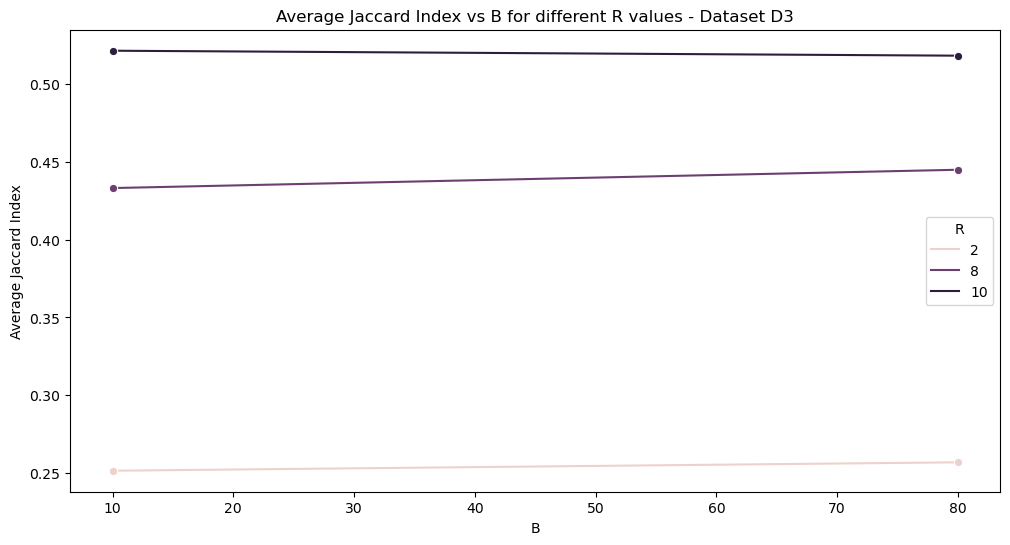

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import itertools
import pickle
from scipy.sparse import csr_matrix


# Function to create sparse matrix
def create_sparse_matrix(data):
    uniprot_ids = list(data.keys())
    structural_features = list(data.values())

    num_features = max(max(indices) for indices in structural_features) + 1

    matrix_data = []
    rows = []
    cols = []

    for row, indices in enumerate(structural_features):
        rows.extend([row] * len(indices))
        cols.extend(indices)
        matrix_data.extend([1] * len(indices))

    sparse_matrix = csr_matrix((matrix_data, (rows, cols)), shape=(len(uniprot_ids), num_features))
    
    return sparse_matrix, uniprot_ids

# Create sparse and dense matrices for both datasets
sparse_matrix_d3, uniprot_ids_d3 = create_sparse_matrix(data_d3)


dense_matrix_d3 = sparse_matrix_d3.toarray()


df_d3 = pd.DataFrame(dense_matrix_d3, index=uniprot_ids_d3)


# Functions for LSHT
def MakeBucketsT(TDocs, perms, N, B, R, NB):
    Buckets = {}
    all_docs = set(range(N))
    for b in range(B):
        SIGS = np.zeros((N, R), dtype="int32")
        for r in range(R):
            perm = perms[b * R + r]
            L = all_docs.copy()
            i = 0
            while len(L) > 0:
                elem = perm[i]
                docs_found = TDocs[elem] & L
                if len(docs_found) > 0:
                    SIGS[list(docs_found), r] = i
                    L = L - docs_found
                i += 1
                if i == len(perm):
                    SIGS[list(L), r] = i
                    L = set()
        for d in range(N):
            bucket = hash(tuple(SIGS[d])) % NB
            Buckets.setdefault((b, bucket), set()).add(d)
    return Buckets

def LSHT(Data, B, R, NB=28934501):
    N, M = Data.shape
    DT = Data.T  # Transpose the matrix
    DataT = [set(np.where(DT[i] == 1)[0]) for i in range(M)]  # Adjust indexing for dense matrix
    P = B * R
    np.random.seed(3)
    perms = [np.random.permutation(M) for _ in range(P)]
    buckets = MakeBucketsT(DataT, perms, N, B, R, NB)
    return buckets

# Calculate Jaccard similarity
def jaccard_similarity(protein1, protein2):
    intersection = np.sum(np.minimum(protein1, protein2))
    union = np.sum(np.maximum(protein1, protein2))
    return intersection / union

# Function to compute average Jaccard index for bands with more than one protein
def calculate_average_jaccard(buckets, uniprot_ids, df):
    average_jaccard_scores = []
    for (b, buck), docs in buckets.items():
        if len(list(buckets[(b,buck)])) < 100:
            if len(docs) > 1:
                combs = itertools.combinations(docs, 2)
                jaccard_scores = []
                for i, j in combs:
                    protein1 = df.iloc[i].values
                    protein2 = df.iloc[j].values
                    jaccard_sim = jaccard_similarity(protein1, protein2)
                    jaccard_scores.append(jaccard_sim)
                average_jaccard_scores.append(np.mean(jaccard_scores))
    return np.mean(average_jaccard_scores) if average_jaccard_scores else 0

# Test different values of B and R
B_values = [10, 80] #20, 60, 
R_values = [2, 8, 10]

# Collect average Jaccard index results for dense_matrix_d3
jaccard_results_d3 = []
for B_val in B_values:
    for R_val in R_values:
        buckets = LSHT(dense_matrix_d3, B_val, R_val)
        print("Bucket done")
        avg_jaccard = calculate_average_jaccard(buckets, uniprot_ids_d3, df_d3)
        jaccard_results_d3.append((B_val, R_val, avg_jaccard))
        print("Jaccard done")


# Convert results to DataFrames
df_jaccard_d3 = pd.DataFrame(jaccard_results_d3, columns=['B', 'R', 'Average Jaccard'])


# Plotting the results
def plot_jaccard_results(df_jaccard, title):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_jaccard, x='B', y='Average Jaccard', hue='R', marker='o')
    plt.xlabel('B')
    plt.ylabel('Average Jaccard Index')
    plt.title(f'Average Jaccard Index vs B for different R values - {title}')
    plt.legend(title='R')
    plt.show()

plot_jaccard_results(df_jaccard_d3, 'Dataset D3')

In [58]:
x = set([1, 4, 5])
x = list(itertools.islice(x, 1))
x

[1]

In [38]:
import random

csr_data, keys_to_index, indices_to_key = convert_to_binary_matrix(data_d3)

# Test different values of B and R
bands_values = [10 ,20, 40, 60, 80, 120]  # Adjust the values as needed
rows_values = [2, 4, 8, 10, 16]  # Adjust the values as needed

s_values = [0.5, 0.85]
probs = get_probabilities(s_values, bands_values, rows_values)

probs_df = pd.DataFrame(probs, columns=["Probability", "Num_band", "Num_row", "similarity"])

promissing_params = probs_df[(((probs_df["Probability"] < 0.3) & (probs_df["similarity"] == 0.5)) & ((probs_df["Probability"] > 0.1) & (probs_df["similarity"] == 0.5))) | ((probs_df["Probability"] > 0.85) & (probs_df["similarity"] == 0.85))]

print("Final promising parameters")
final_promising = promissing_params[promissing_params.duplicated(subset=["Num_band", "Num_row"])]

bands_values = [40, 60, 80]  # Adjust the values as needed
rows_values = [8]  # Adjust the values as needed

s_values = [0.5, 0.6, 0.7, 0.85, 0.9, 0.95]
probs = get_probabilities(s_values, bands_values, rows_values)
final_probs_df = pd.DataFrame(probs, columns=["Probability", "Num_band", "Num_row", "similarity"])
display(final_probs_df)
# => use b = 60, r = 8 or b = 80, r = 8

,Probability,Num_band,Num_row,similarity
0,0.000026,10,8,0.20
1,0.038383,10,8,0.50
2,0.155819,10,8,0.60
3,0.447755,10,8,0.70
4,0.958468,10,8,0.85
5,0.000001,10,10,0.20
6,0.009723,10,10,0.50
7,0.058847,10,10,0.60
8,0.249144,10,10,0.70
9,0.888356,10,10,0.85


Final promising parameters


,Probability,Num_band,Num_row,similarity
0,0.144916,40,8,0.50
1,0.492142,40,8,0.60
2,0.906991,40,8,0.70
3,0.999997,40,8,0.85
4,1.000000,40,8,0.90
5,1.000000,40,8,0.95
6,0.209298,60,8,0.50
7,0.638079,60,8,0.60
8,0.971635,60,8,0.70
9,1.000000,60,8,0.85


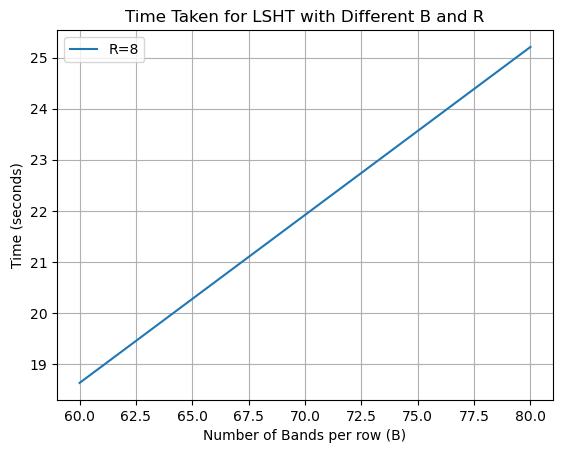

In [33]:
# Collect timing results of the most promissing parameters
bands_values = [60, 80]  # Adjust the values as needed
rows_values = [8]  # Adjust the values as needed

buckets_results = {}
timing_results = {}
for b_val in bands_values:
    for r_val in rows_values:
        specific_buckets, specific_time_results = time_LSHT(csr_data, b_val, r_val)
        buckets_results[(b_val, r_val)] = specific_buckets
        timing_results[(b_val, r_val)] = specific_time_results

plot_timing_results(bands_values, rows_values, timing_results)

In [324]:
import random
import math

test_bucket = buckets_results[(40,8)]
len_bucket = len(test_bucket)

sample_size = math.floor(len_bucket / 10)
random_keys = random.sample(list(test_bucket.keys()), sample_size)

# Create a new dictionary with the sampled keys
sampled_dict = {key: test_bucket[key] for key in random_keys}

In [237]:
from itertools import combinations
counter = 0
for b, buck in buckets:
    # print(counter)
    counter += 1
    if len(list(buckets[(b,buck)])) < 1000:
        combs = combinations(buckets[(b,buck)], 2)
        for i, j in combs:
            document_i = indices_to_key[i]
            document_j = indices_to_key[j]
            true_sim = JaccardSim(csr_data.getrow(i).toarray()[0], csr_data.getrow(j).toarray()[0])
            if true_sim > 0.5:
                print("Documents %s and %s are in truth %7.4f similar"  % (document_i , document_j, true_sim))
        else:
            continue
        break

Documents O60242 and O15040 are in truth  0.5013 similar
Documents O14594 and O14976 are in truth  0.5257 similar
Documents O14594 and O15047 are in truth  0.5050 similar
Documents O75173 and O00468 are in truth  0.5082 similar
Documents O00468 and O15040 are in truth  0.5260 similar
Documents O00468 and O75037 are in truth  0.5158 similar
Documents A0A0C4DH34 and A0A075B6R2 are in truth  0.6352 similar
Documents O60242 and O15040 are in truth  0.5013 similar
Documents O75037 and O43150 are in truth  0.5114 similar
Documents A2PYH4 and O14976 are in truth  0.5233 similar
Documents O60242 and O15040 are in truth  0.5013 similar
Documents O00555 and O75153 are in truth  0.5444 similar
Documents A0A0B4J2D9 and A0A0C4DH73 are in truth  0.7333 similar
Documents A0A0C4DH34 and A0A075B6R2 are in truth  0.6352 similar
Documents O00267 and O15047 are in truth  0.5054 similar
Documents A0A0C4DH34 and A0A075B6R2 are in truth  0.6352 similar
Documents O60437 and O75037 are in truth  0.5195 similar

In [ ]:
bands = 20 # TODO fill in values
rows = 20

# Number of permutations
# is product of bands and rows
num_perm = bands * rows

# Generate MinHash signatures from sparse matrix
minhashes = create_minhash_from_sparse(csr_data, num_perm)

# Define threshold
threshold = 0.9
lsh = init_minhash_lsh(num_perm, threshold)

# Populate lsh with calculated MinHash signatures
for doc, minhash in zip(data_d3.keys(), minhashes):
    lsh.insert(doc, minhash)
    
print("\nLSH index created and signatures inserted.")

# Example Query: Find similar items to specific item key: P28223 => Bonus question
query_key = "P28223" # Code to answer the bonus question
query_index = keys_to_index[query_key]
results = lsh.query(minhashes[query_index])
print(f"Items similar to {query_key}: {results}")
len(results)

# delete variables from memory so rest of code doesn't get affected
del minhashes
del lsh

### Your short analysis here

Plan:
- use sparse matrices!
- use MinHashing to calculate the Jaccard Similarity as it is a good approach for large datasets (like d4)
- use LSHT instead of LSH as it heavily outperformes LSH for sparse matrices (which is the case for this data)


## 3. Do dimensionality reduction 

Use the techniques discussued in class to make an appropriate dimensional reduction of the selected dataset. It is not necesary to be extensive, **it is better to select one approach and do it well than try a lot of techniques with poor insights and analysis**

It is important to do some sensitivity analysis, relating the dataset size reduction to the loss of information



In [8]:
### Add supporting functions here
import math
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

def convert_to_binary_matrix(data):
    # Extract all unique values to create the universe of elements
    all_values = set()
    for values in data.values():
        all_values.update(values)

    # Create a mapping from values to index
    value_to_index = {value: idx for idx, value in enumerate(all_values)}

    # Number of unique elements
    num_elements = len(all_values)

    # Prepare data for csr_matrix
    rows = []
    cols = []
    data_values = []

    for key, values in data.items():
        for value in values:
            rows.append(key)
            cols.append(value_to_index[value])
            data_values.append(1)  # Presence of the element

    # Convert document IDs to numerical indices
    keys_to_index = {}
    indices_to_key = {}
    for idx, doc in enumerate(data.keys()):
        keys_to_index[doc] = idx
        indices_to_key[idx] = doc
    row_indices = [keys_to_index[doc] for doc in rows]

    # Create and return CSR matrix
    return csr_matrix((data_values, (row_indices, cols)), shape=(len(data), num_elements)), keys_to_index, indices_to_key

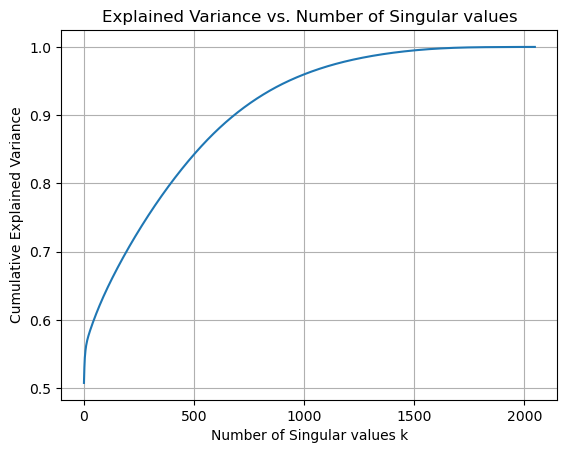

Number of singular values to reach 60.0% explained variance: 47
Number of singular values to reach 75.0% explained variance: 288
Number of singular values to reach 80.0% explained variance: 395
Number of singular values to reach 90.0% explained variance: 683
Number of singular values to reach 95.0% explained variance: 929

The MSE with 929 components is:  0.0077


In [9]:
### Add processing code here
csr_data, keys_to_index, indices_to_key = convert_to_binary_matrix(data_d3)

total_variance = np.sum(csr_data.power(2))

U, S, V = svds(csr_data.astype(float), k=min(csr_data.shape) - 1)

# Since svds returns the singular values in ascending order, sort them in descending order
sorted_indices = np.argsort(S)[::-1]
S_sorted = S[sorted_indices]
U_sorted = U[:, sorted_indices]
V_sorted = V[sorted_indices, :]

cumulative_explained_variance = np.cumsum(S_sorted**2) / total_variance
thresholds = [0.6, 0.75, 0.8, 0.9, 0.95]

k_values = np.arange(1, min(csr_data.shape))
plt.plot(k_values, cumulative_explained_variance)
plt.xlabel("Number of Singular values k")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Singular values")
plt.grid(True)
plt.show()

for threshold in thresholds:
    # get the index od the optimal number of k
    k_optimal = np.argmax(cumulative_explained_variance >= threshold) + 1
    print(f"Number of singular values to reach {threshold*100}% explained variance: {k_optimal}")

final_threshold = 0.95
k_optimal = np.argmax(cumulative_explained_variance >= final_threshold) + 1

U, S, V = svds(csr_data.astype(float), k=k_optimal) # perform SVD with optimal k

reconstructed_matrix = U @ np.diag(S) @ V
original_dense_matrix = csr_data.toarray()

MSE=((original_dense_matrix - reconstructed_matrix)**2).mean()
print("")
print("The MSE with %d components is: %7.4f" % (k_optimal, MSE))

## 4. Discuss your findings [to fill on your own]

* Comment your results above
* Discuss how could they be used for the full Uniprot that currently has about [248 Million proteins](https://www.uniprot.org/uniprotkb/statistics)

### Summary of code and key findings:

To perform dimensionality reduction there are a many different options. In a Data Mining concept doing Feature Selection is a rather uncommon approach as the there is a large amount of data, containing usually many features. Therefore dimensionality reduction is a more common approach for these large amounts of data. The most two common approaches are PCA and SVD. As our data is very sparse we decide to stick to SVD as it is known as a good option to work with sparse matrices.

In SVD the data, in form of a matrix, get divided into three matrices: U, S, V. The method transforms the original data into a new set of orthogonal basis vectors (singular vectors) that capture the most significant directions of variance in the data. For this reason the method requires the parameter k, which determines the number of singular values the data should be transformed in. Depending on the percentage of explained variance the transformed data should still include, this parameter has to be chosen accordingly.

As calculating every possible configuration of k would be quite computational intensive, this approach is not an option. As k, determines the number of singular vectors in the transformed matrices, we know, that setting this value to the number of columns/ features of the original data will result in a explained variance of 100% and therefore no loss will be achieved. Looking at the matrix S, which is a diagonal matrix with singular values on the diagonal, we can obtain the singular values that the data got transformed to. Using these values and performing the cumulative sum of the values squared and divide this by the total variance of the data, we get the cumulative explained variance of the singular values. By doing so we can investigate the percantage of explained variance that x-number of singular values capture/ explain. This way we can find the optimal value for k to achieve the desired explained variance in the transformed data.

Looking at the implementation, we first convert our data into a binary sparse matrix. To perform SVD we are using **svds()** from scipy.sparse.linalg. This method can handle sparse matrices in the scipy-format. We set k to the number of columns of our data - 1, as the index starts at 0. As the resulting matrices from svds() returns the singular values in ascending order, we need to sort them in descending order. Only this way we can easily cumulate the sum of the singular values. In order to get the cumulative explained variance we apply the following formular: **np.cumsum(S_sorted^2) / total_variance**

Plotting the results gives us interesting insights (total number of columns = 2048 for data_d3):
- Using only 47 singular values we already achieve 60% of explained variance
- Using 288 we achieve 75%
- Using 683 we achieve 90%
- Using 929 we achieve 95% of explained variance. This is less than half of all columns of the original data

Looking at these results it becomes clear why dimensionality reduction is so powerful and useful.

As we don't want to loose too much information we decide on a threshold of 95%, therefore k = 929. Lastly we calculate the SVD with now the optimal number of k for our defined goal. **The resulting U matrix contains the new representation of the reduced data.** As a last step we calculate the MSE of the original data with the reassembled data, using the three created matrices, and get a value of 0.0077. This shows us, that almost no loss happend. But still, the new matrix U only contains 929 columns (instead of 2048 in the original).


### Full Applicability to Uniprot:

In order to perform LSH and SVD with the whole scope of data different aspects need to be taken into account:

First, Uniprot's vast dataset, composed by approximately 248 million proteins, will require distributed computing approaches to manage both the computational load and the storage effectively.

Converting the data into binary format and then storing them in a sparse matrix is definitely necessary, to reduce computational load and used memory storage.

##### For LSH:
* Parameter Optimization: For example involving more sophisticated methods to determine the optimal number of bands and rows per band (Grid search for cross validation, ML models). As we saw when plotting the time taken for the different settings, choosing the correct number of bands and rows is of high importance.
* Integration with intense Biological Validation: Ensuring that the similar pairs identified through LSH are biologically relevant is essential. This could involve integrating LSH outputs with other biological databases or literature (Literature mining and Database integration) to verify functional relationships.

##### For SVD:
Currently our approach for SVD is already very efficient in our opinion, but a few things need to be adapted:
- Converting the data into binary and storing them in a sparse matrix is very important, especially as the dimensions of the data increase
- The approach to identify the optimal k needs to be adapted:
    - Probably calculating the SVD with k = the number of columns in the data is not a good approach. Therefore a more efficient way to calculate the optimal k needs to be found. But as we see from our results (plot) already a small percentage of the columns explain a large amount of the data. For this reason testing different k's in the range of column-length / 4 should already give promising results
- another thought is to investigate the number of dimensions for the whole Uniport data. It could be, that the number of columns will exceed the number of rows. If this is the case, transposing the matrix and applying SVD on the rows instead of the columns could be a good approach.

##### General Considerations for Implementation:
* Distributed Computing: Both LSH and dimensionality reduction should be implemented within a distributed computing framework to manage the data volume effectively. Technologies like Apache Spark or Hadoop would be employed to parallelize these processes across multiple computing nodes.
* Incremental Learning and Processing: Considering the dynamic nature of Uniprot, where new proteins are continually added, incremental approaches to LSH and SVD might be necessary. This would involve updating the models periodically without reprocessing the entire dataset from scratch.